# Lab 4

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

hf.keys()

<KeysViewHDF5 ['data']>

In [3]:
data = np.array(hf.get('data'))

data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [4]:
hf.close()

# Problem 1
1. Here we are given simulated data describing the number of gamma particles detected every 100 milliseconds in 90 minute cycles, at varying positions of earth longitude and solar phase. Let's start by plotting the data to get a sense of the features.

In [5]:
plot_points = 250000

ValueError: x and y must have same first dimension, but have shapes (250000,) and (200, 10)

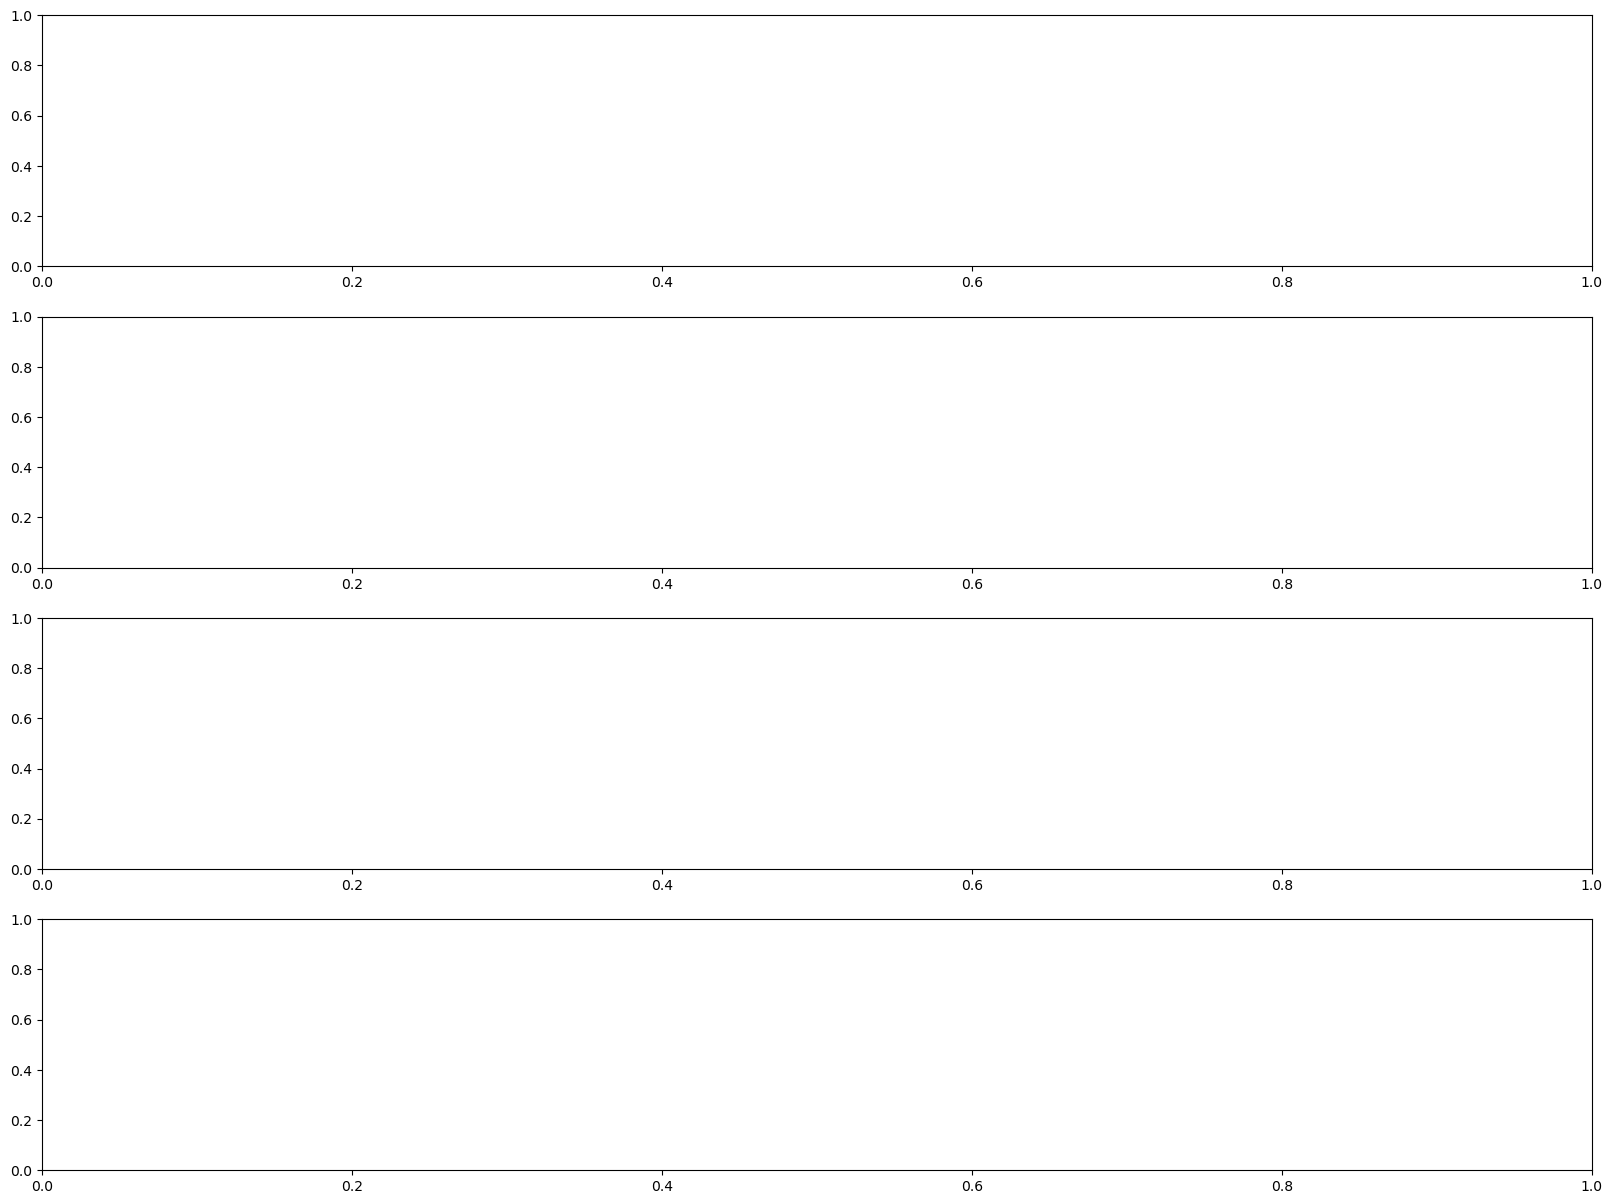

In [21]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1)
x = np.arange(plot_points)
ax1.plot(x,data[0,:plot_points], '.')
ax2.plot(x, data[1,:plot_points], '.')
ax3.plot(x, data[2,:plot_points], '.')
ax4.plot(x, data[3,:plot_points], '.')
ax1.set_title('Time')
ax2.set_title('solar phase')
ax3.set_title('Earth Longitude')
ax4.set_title('Counts')

Each of our features, except for time of course, appear to operate periodically. Both the solar phase and earth longitude increase linearly before folding back around, presumably at the point where the satellite reaches its initial position. The background pdf also operates periodically likely for the same reason, though all three are offset by a certain phase. Upon visual inspection I would think that the background does contain signal contamination, simply due to the presence of significant outliers in the dataset, though without developing a model to represent our background we cannot say this for certain. Let's take a closer look at where the distribution folds over to get a better idea of how to come up with a pdf to describe our background.

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0, 10)

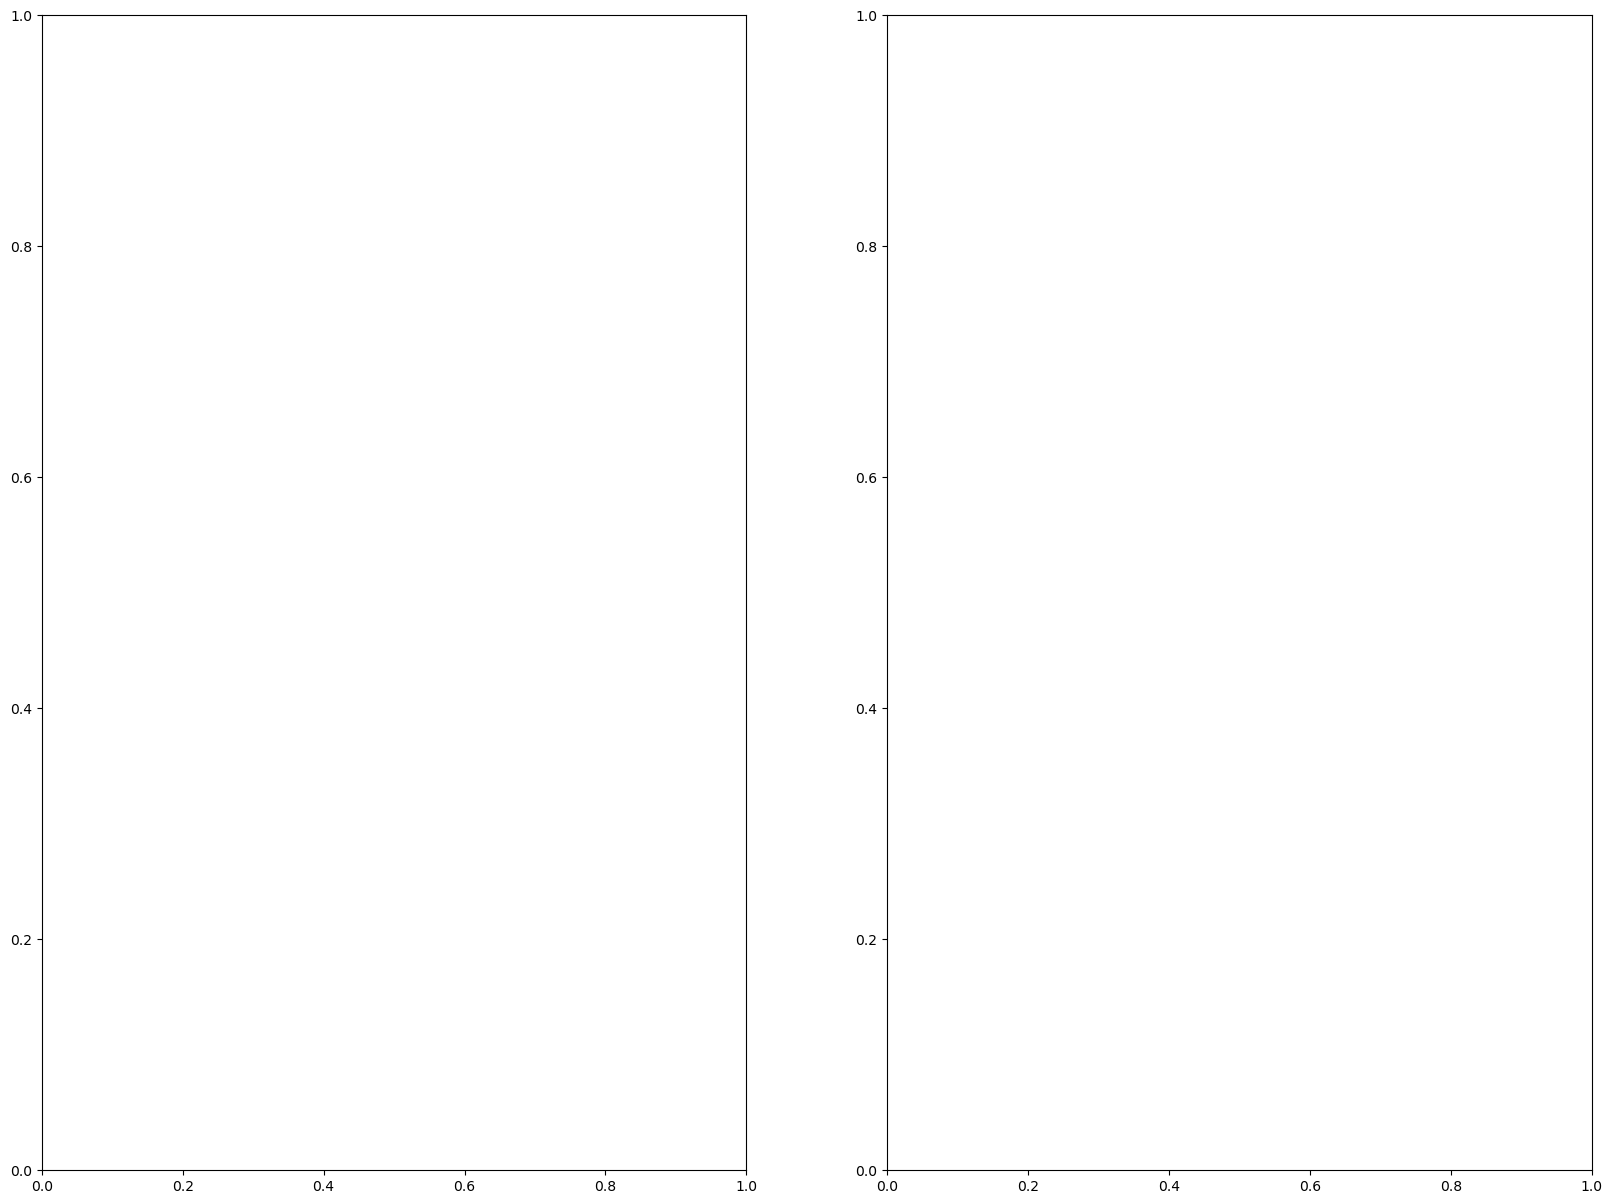

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(np.arange(40000, 41000, 1), data[3, 40000:41000], '.')
ax2.plot(np.arange(94000,95000,1), data[3, 94000:95000], '.')
ax1.set_xlabel('Measurement')
ax1.set_ylabel('Count')
ax2.set_xlabel('Measurement')

2) These plots allow us to see more closely exactly where the background "loops" per say, which looks to be near bin 40,500 and bin 94,500. Seeing that this distribution is nearly identical in both of the ranges plotted, we can say that the background repeats every 54,000 bins. This lines up with the orbit of the satellite, which completes an orbit every 90 minutes. 90 minutes is equal to 54,000 * 100 ms, which further upholds this claim, as each point is representative of a count over 100 ms. Knowing the period of the cycle, we now need only to determine a representative pdf over 54,000 points and can then extrapolate that to all of our data.

3. It becomes clear immediately that some sort of poisson distribution would be best used to describe our background as the background is made up of a count of independent events over a set period of time. However, this count decreases exponentially over time. To start, we should find an estimated average close to the point it loops and soon after it loops to find the mean of the distribution we should start and end with.

In [8]:
slice_1 = data[3, 40400:40500]
slice_2 = data[3, 94400:94500]
slice_3 = data[3, 40500:40600]
slice_4 = data[3, 94500:94600]

total_left = np.sum(slice_1) + np.sum(slice_2)
total_right = np.sum(slice_3) + np.sum(slice_4)

mean_left = total_left/200
mean_right = total_right/200
print(mean_left, mean_right)

5.675 11.405


We could increase our accuracy further by averaging over more loops, however for our purposes this should be enough for now. Using this knowledge, we want to start with a poisson of mean 11.405 that decreases exponentially over 54,000 bins of 100ms to a poisson with a mean of 5.675

In [9]:
bins = np.arange(40500, 94500, 1)

mean = lambda x: mean_left + (mean_right-mean_left)**(1-(((x+13500)%54000)/54000))

ValueError: x and y must have same first dimension, but have shapes (54000,) and (0, 10)

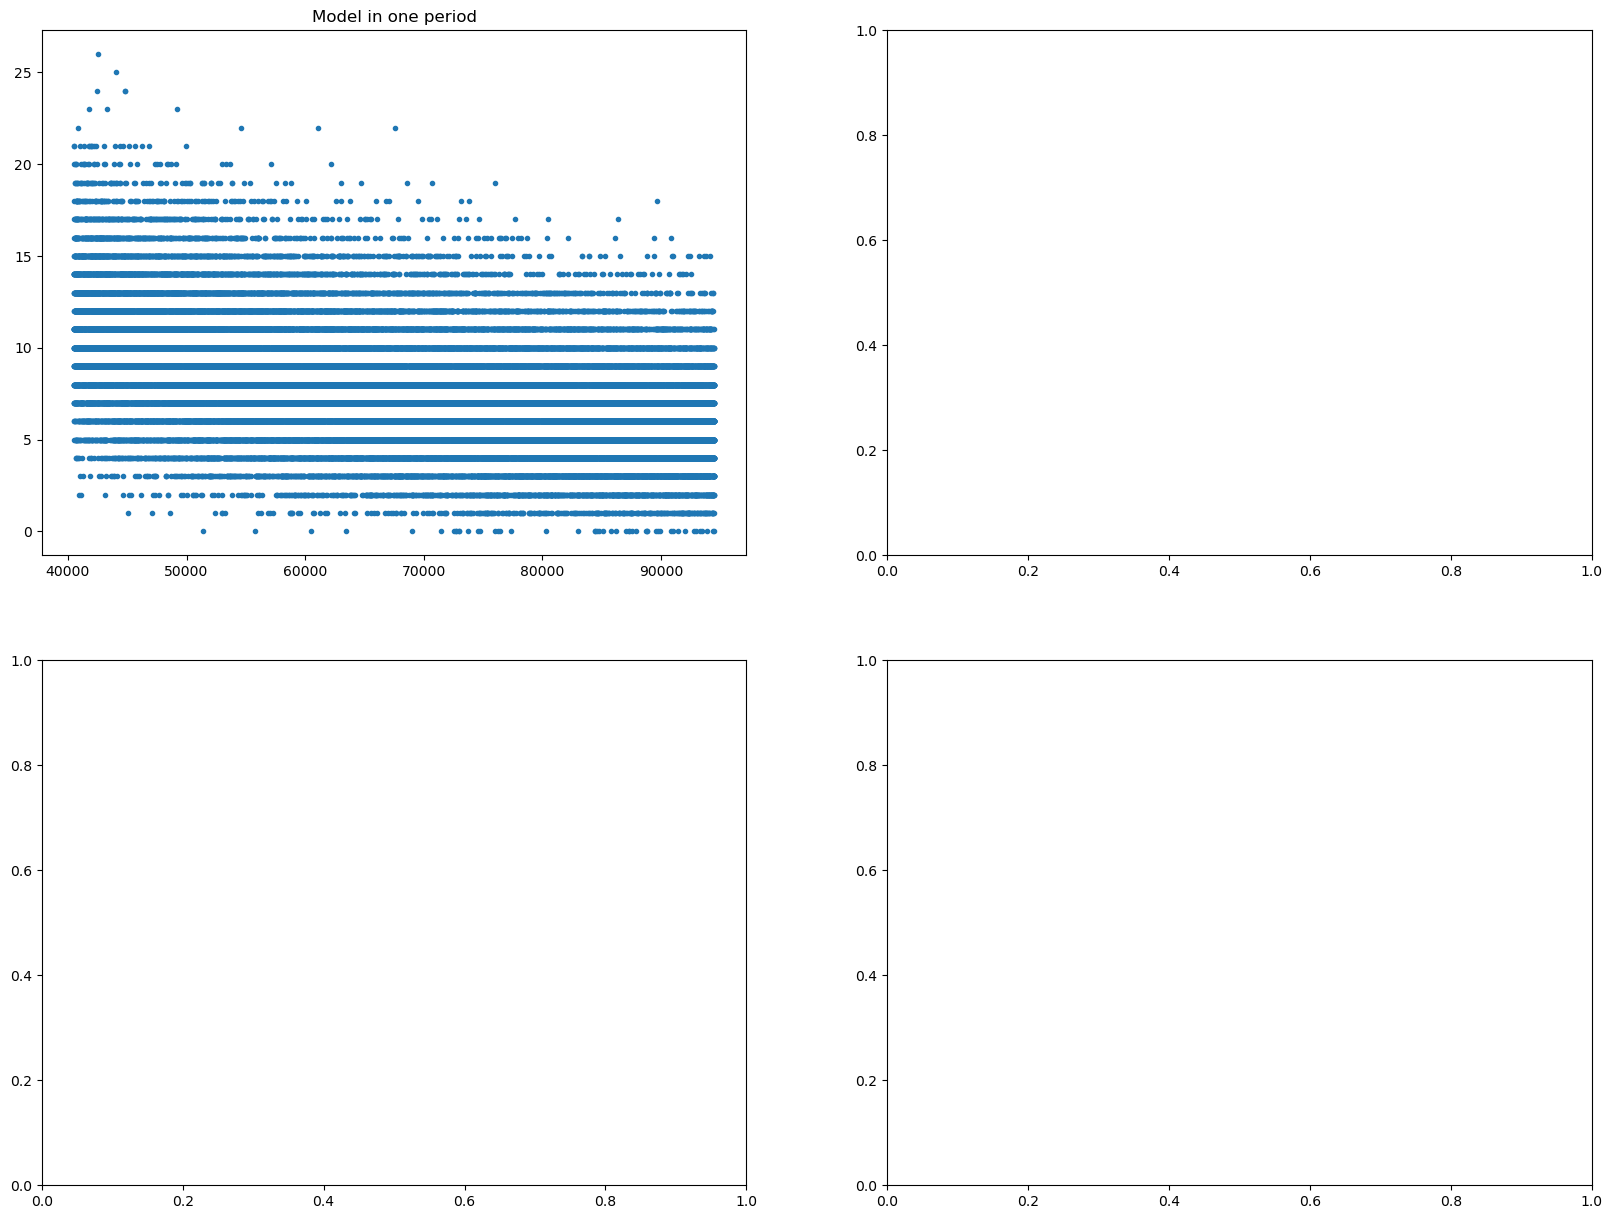

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.plot(bins, stats.poisson.rvs(mean(bins),size=54000, loc=0), '.')
ax1.set_title('Model in one period')
ax2.plot(bins, data[3, bins[0]:(bins[-1]+1)], '.')
ax2.set_title('Data in one period')
ax3.plot(x, stats.poisson.rvs(mean(x),size=plot_points, loc=0), '.')
ax3.set_title('Model over many periods')
ax4.plot(x, data[3, :plot_points], '.')
ax4.set_title('Data over many periods')

The model is a fairly good predictor of our background pdf. However, the tail end just before the end of the period is somewhat more wide than that of the real background. As such, let's try rounding the tail end of our distribution down as this should help narrow it down to more closely resemble the background.

ValueError: x and y must have same first dimension, but have shapes (54000,) and (0, 10)

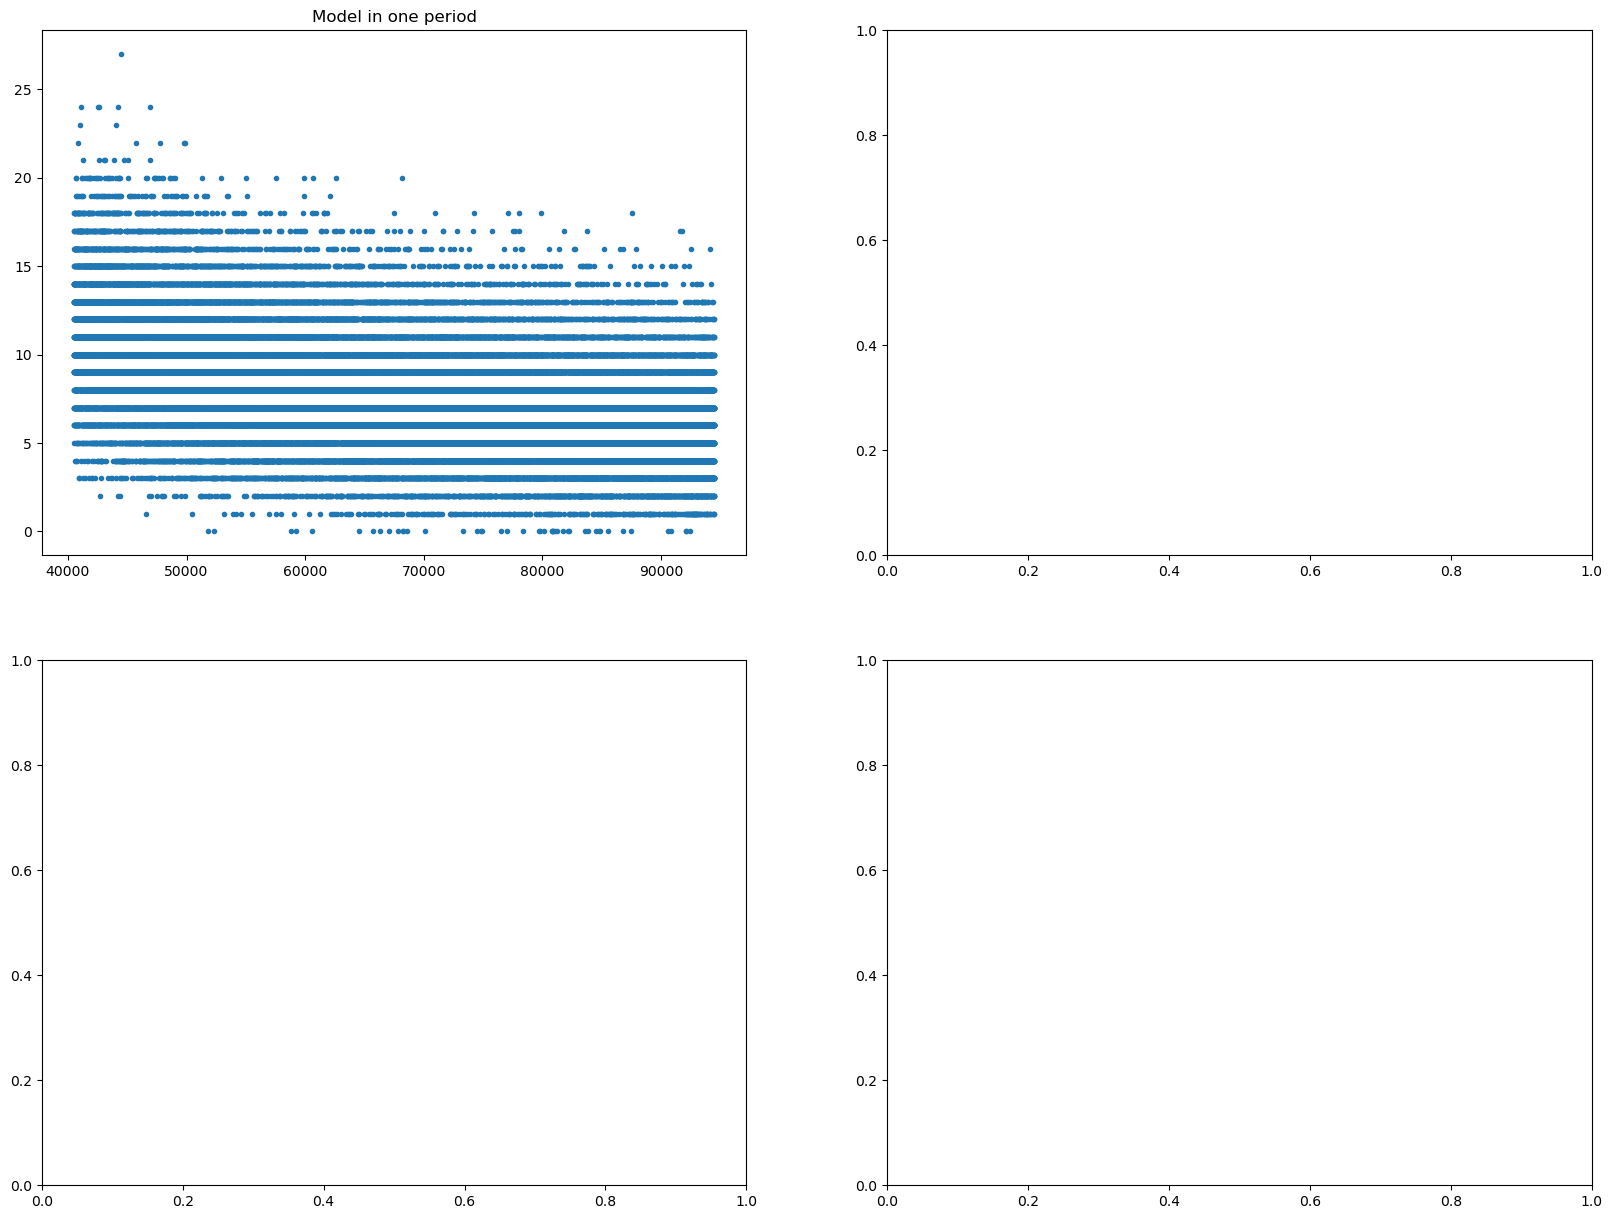

In [24]:
mean_left = 5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.plot(bins, stats.poisson.rvs(mean(bins),size=54000, loc=0), '.')
ax1.set_title('Model in one period')
ax2.plot(bins, data[3, bins[0]:(bins[-1]+1)], '.')
ax2.set_title('Data in one period')
ax3.plot(x, stats.poisson.rvs(mean(x),size=plot_points, loc=0), '.')
ax3.set_title('Model over many periods')
ax4.plot(x, data[3, :plot_points], '.')
ax4.set_title('Data over many periods')

After making this adjustment, the background pdf more closely resembles the real dataset, though with some more tweaking one could fine tune the model to become a better representation. For our purposes this model should do adequately.

4. Using the pdf we've come up with, what's the 5-sigma threshold at various times?

In [12]:
times = np.arange(40500,94501,10000)
prob = stats.norm.cdf(5)
print(prob)
for time in times:
    val = stats.poisson.ppf(prob, mean(time))
    print('5-sigma at time {:.6} is {} counts'.format(data[0,time],int(val)))

0.9999997133484281
5-sigma at time 9.40684e+08 is 32 counts
5-sigma at time 9.40685e+08 is 29 counts
5-sigma at time 9.40686e+08 is 26 counts
5-sigma at time 9.40687e+08 is 24 counts
5-sigma at time 9.40688e+08 is 23 counts
5-sigma at time 9.40689e+08 is 22 counts


# Problem 2

1. In this problem we're given a stack of simulated telescope images. In it we'll be looking for the faintest stars present in these images (stars above 5 sigma of our background).

In [13]:
hf2 = h5py.File('images.h5', 'r')
hf2.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [14]:
data = hf2['imagestack']
data.shape

(200, 200, 10)

2. Let's start by exploring the data and try to determine a method to find a pdf to describe the background.

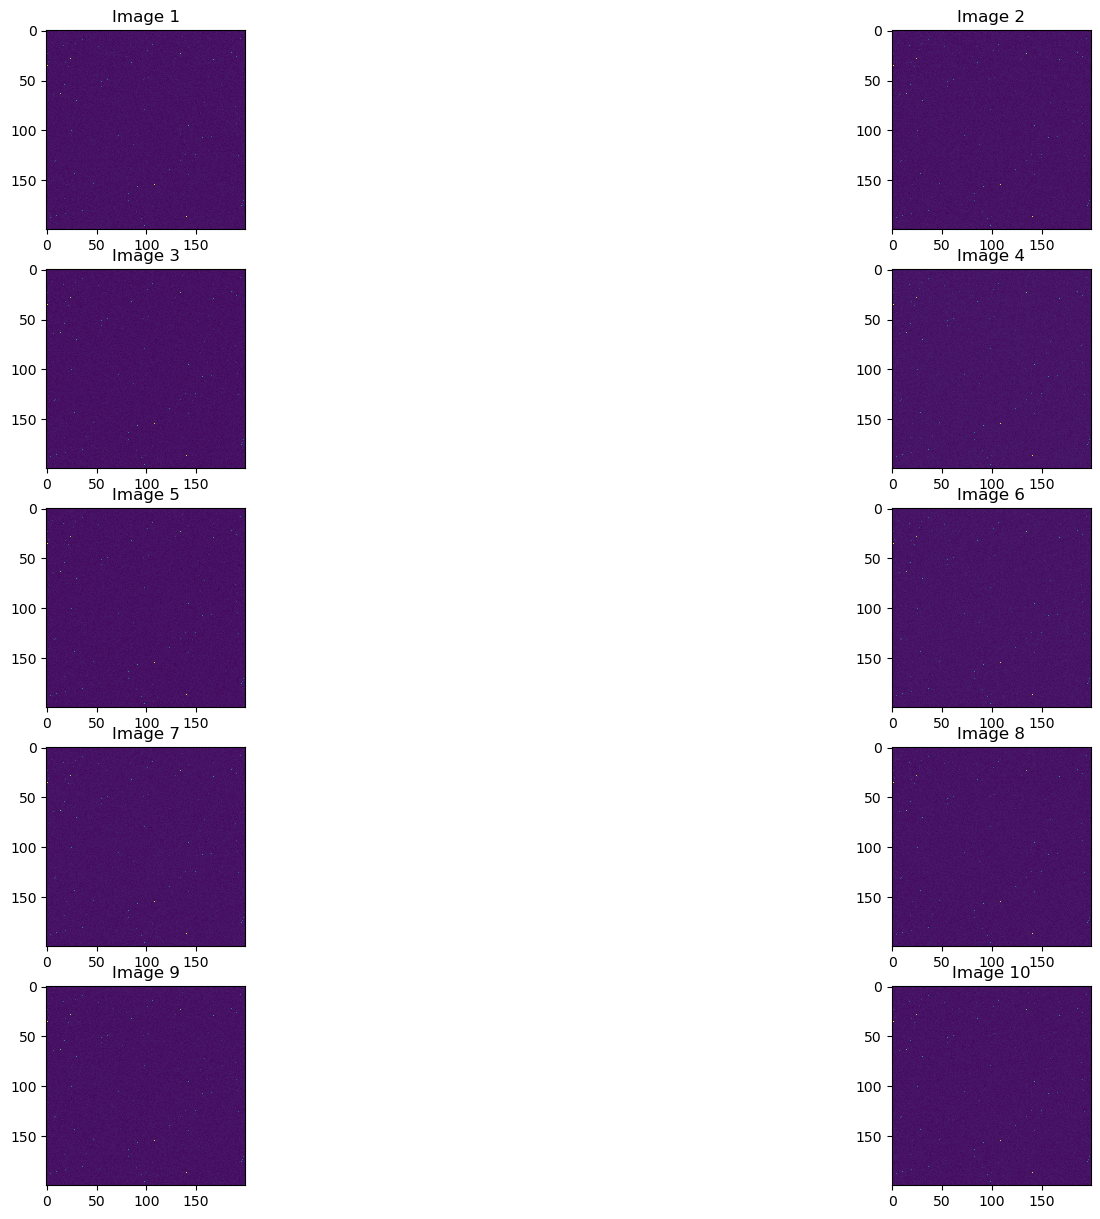

In [25]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10)) = plt.subplots(5,2)

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]

for axis in range(len(axes)):
    axes[axis].imshow(data[:,:,axis])
    axes[axis].set_title('Image {}'.format((axis+1)))

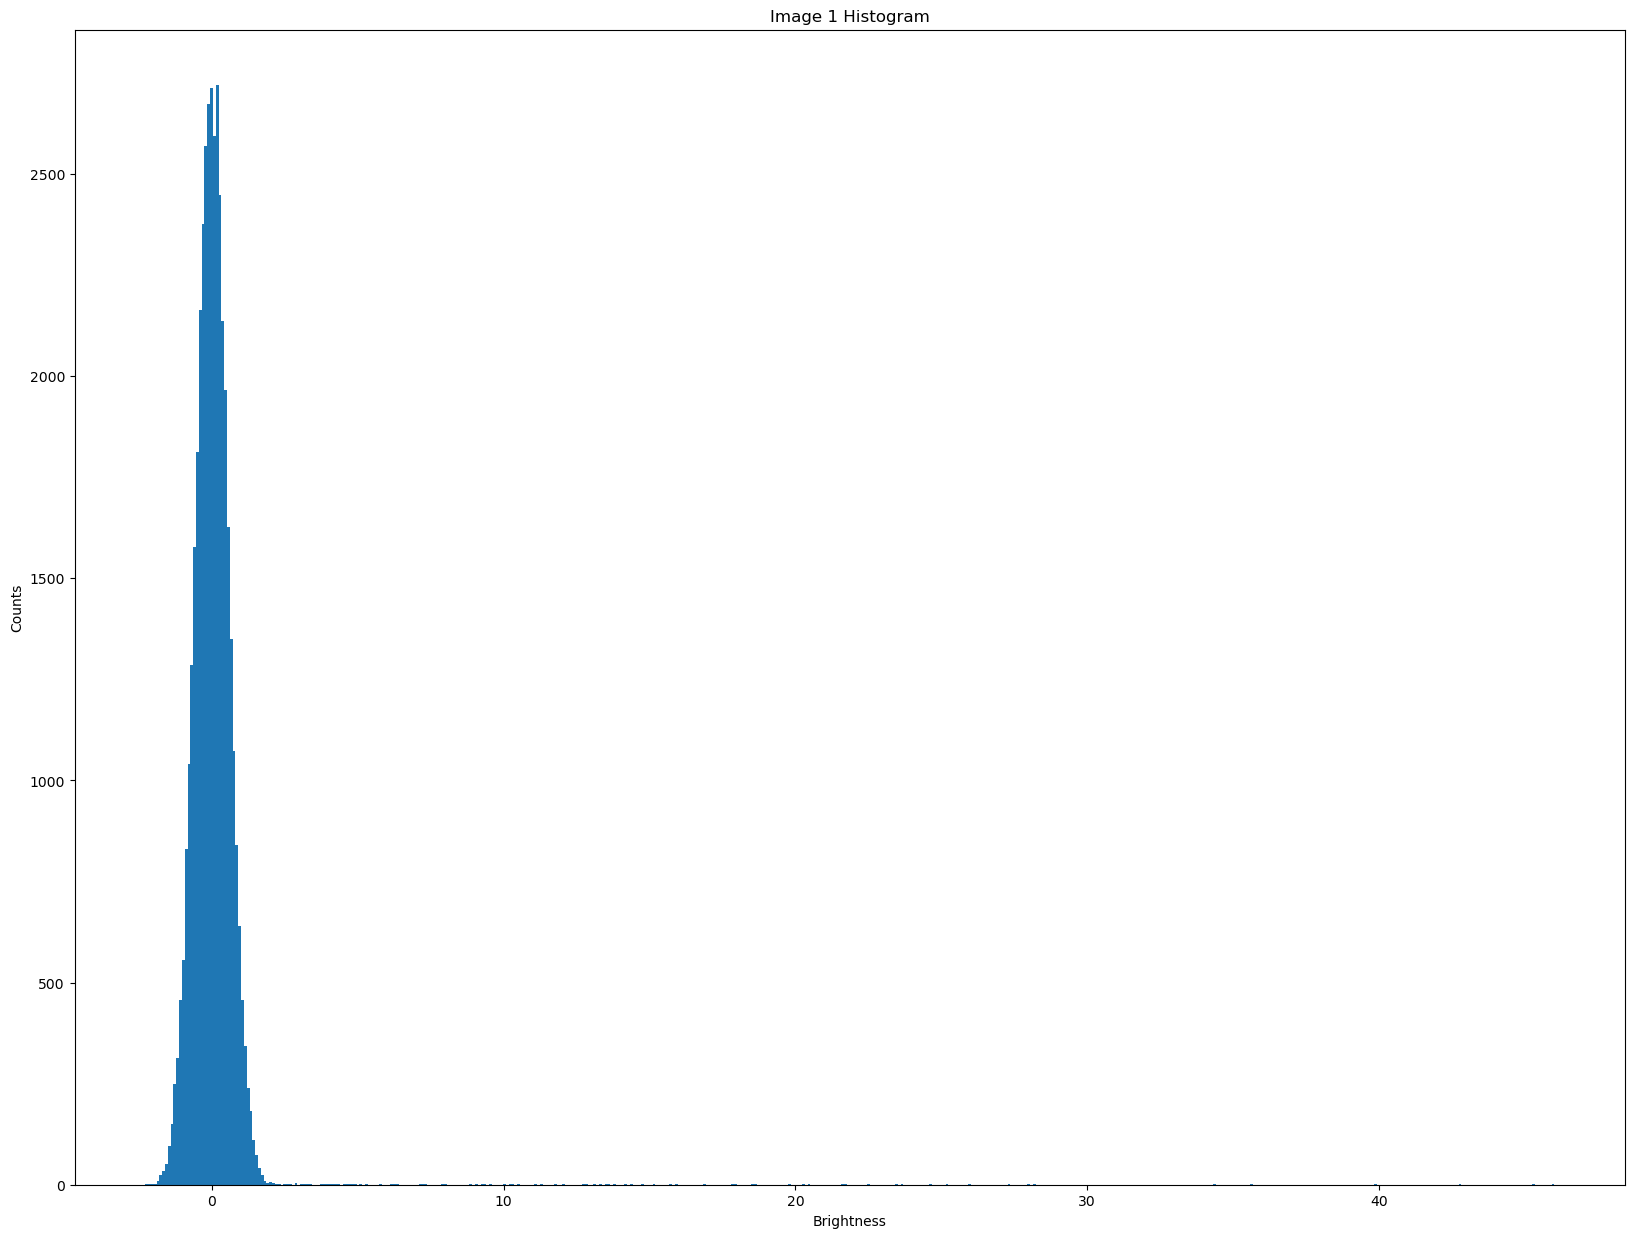

In [26]:
first_image = data[:,:,0]
first_image = first_image.flatten()
plt.hist(first_image, 500)
plt.xlabel('Brightness')
plt.ylabel('Counts')
plt.title('Image 1 Histogram')
plt.show()

The distribution here appears to follow a very sharp gaussian distribution with outliers north of the bulk of our data representing possible stars. Upon visual inspection the background between images appears to be the same, or at least indistinguishable, so the pdf we come up with for this image should be the same for our other images as well since we are only looking for stars present in all images. Since the outliers in any case are highly unlikely to be part of our background, we'll exclude these when performing calculations to come up with the background.

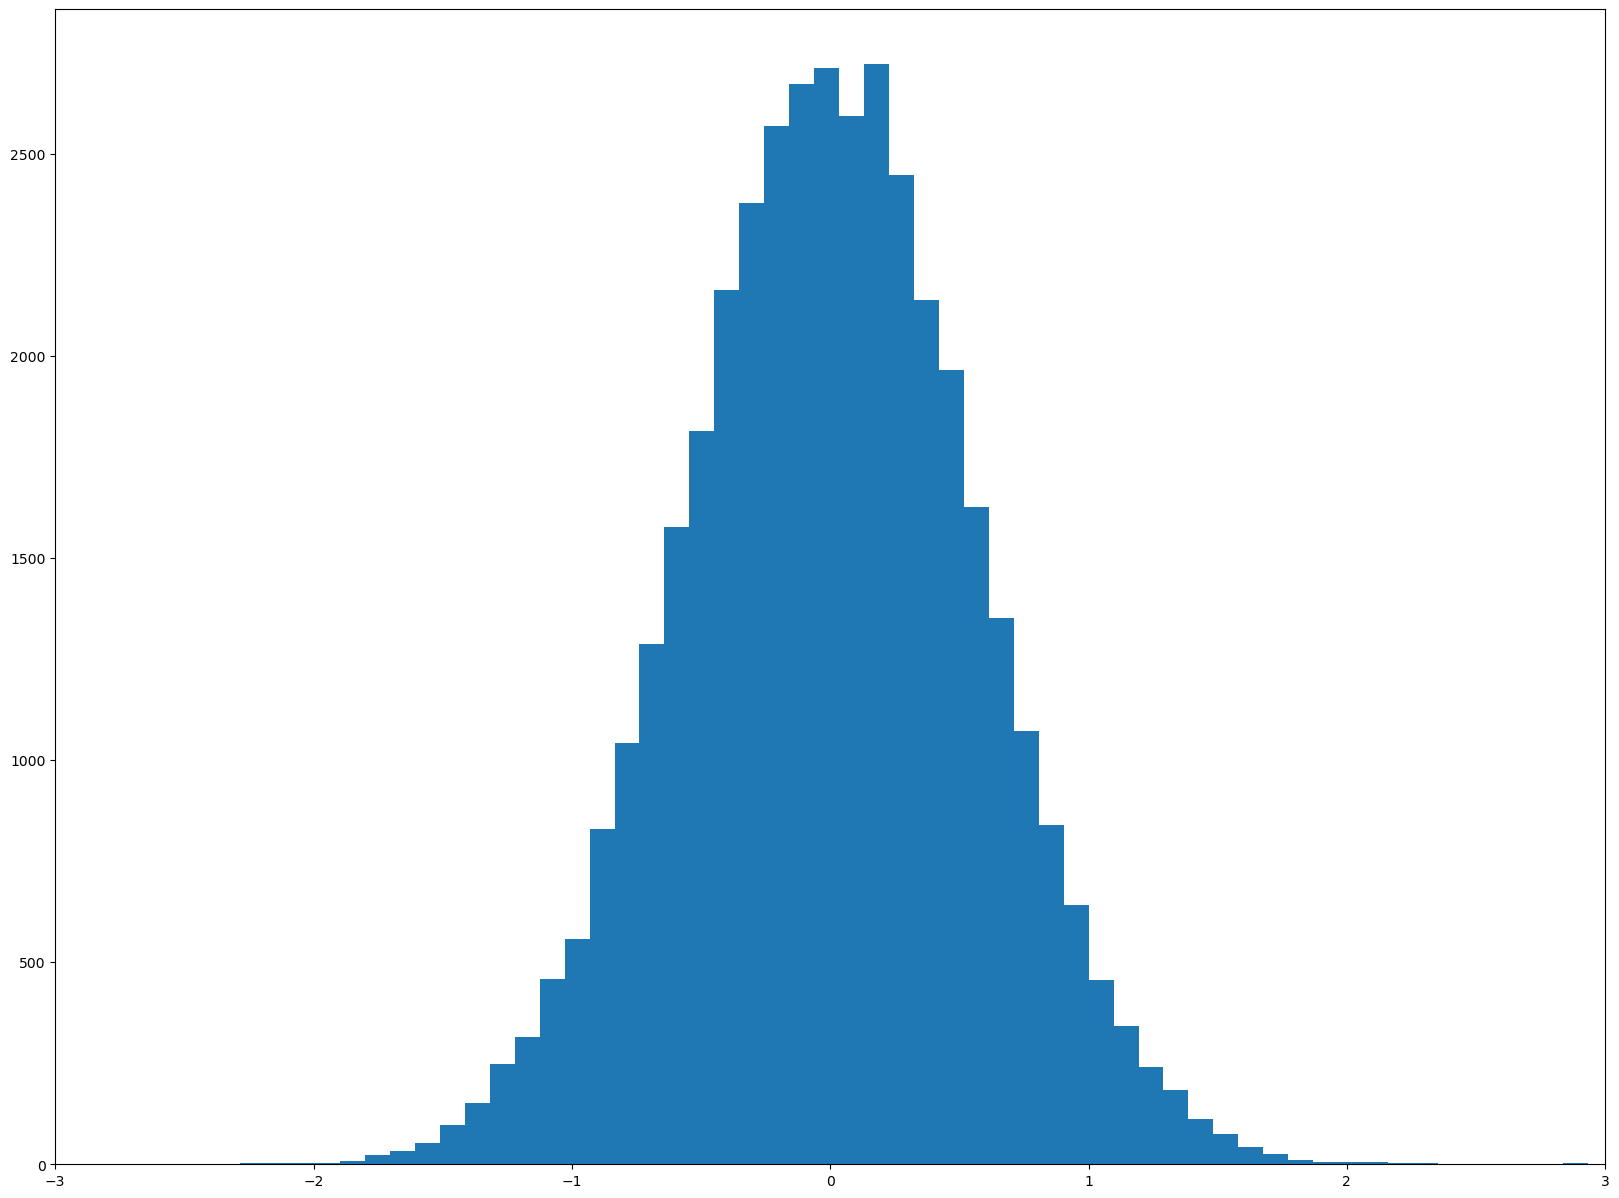

In [17]:
plt.hist(first_image, 500)
plt.xlim([-3, 3])
plt.show()

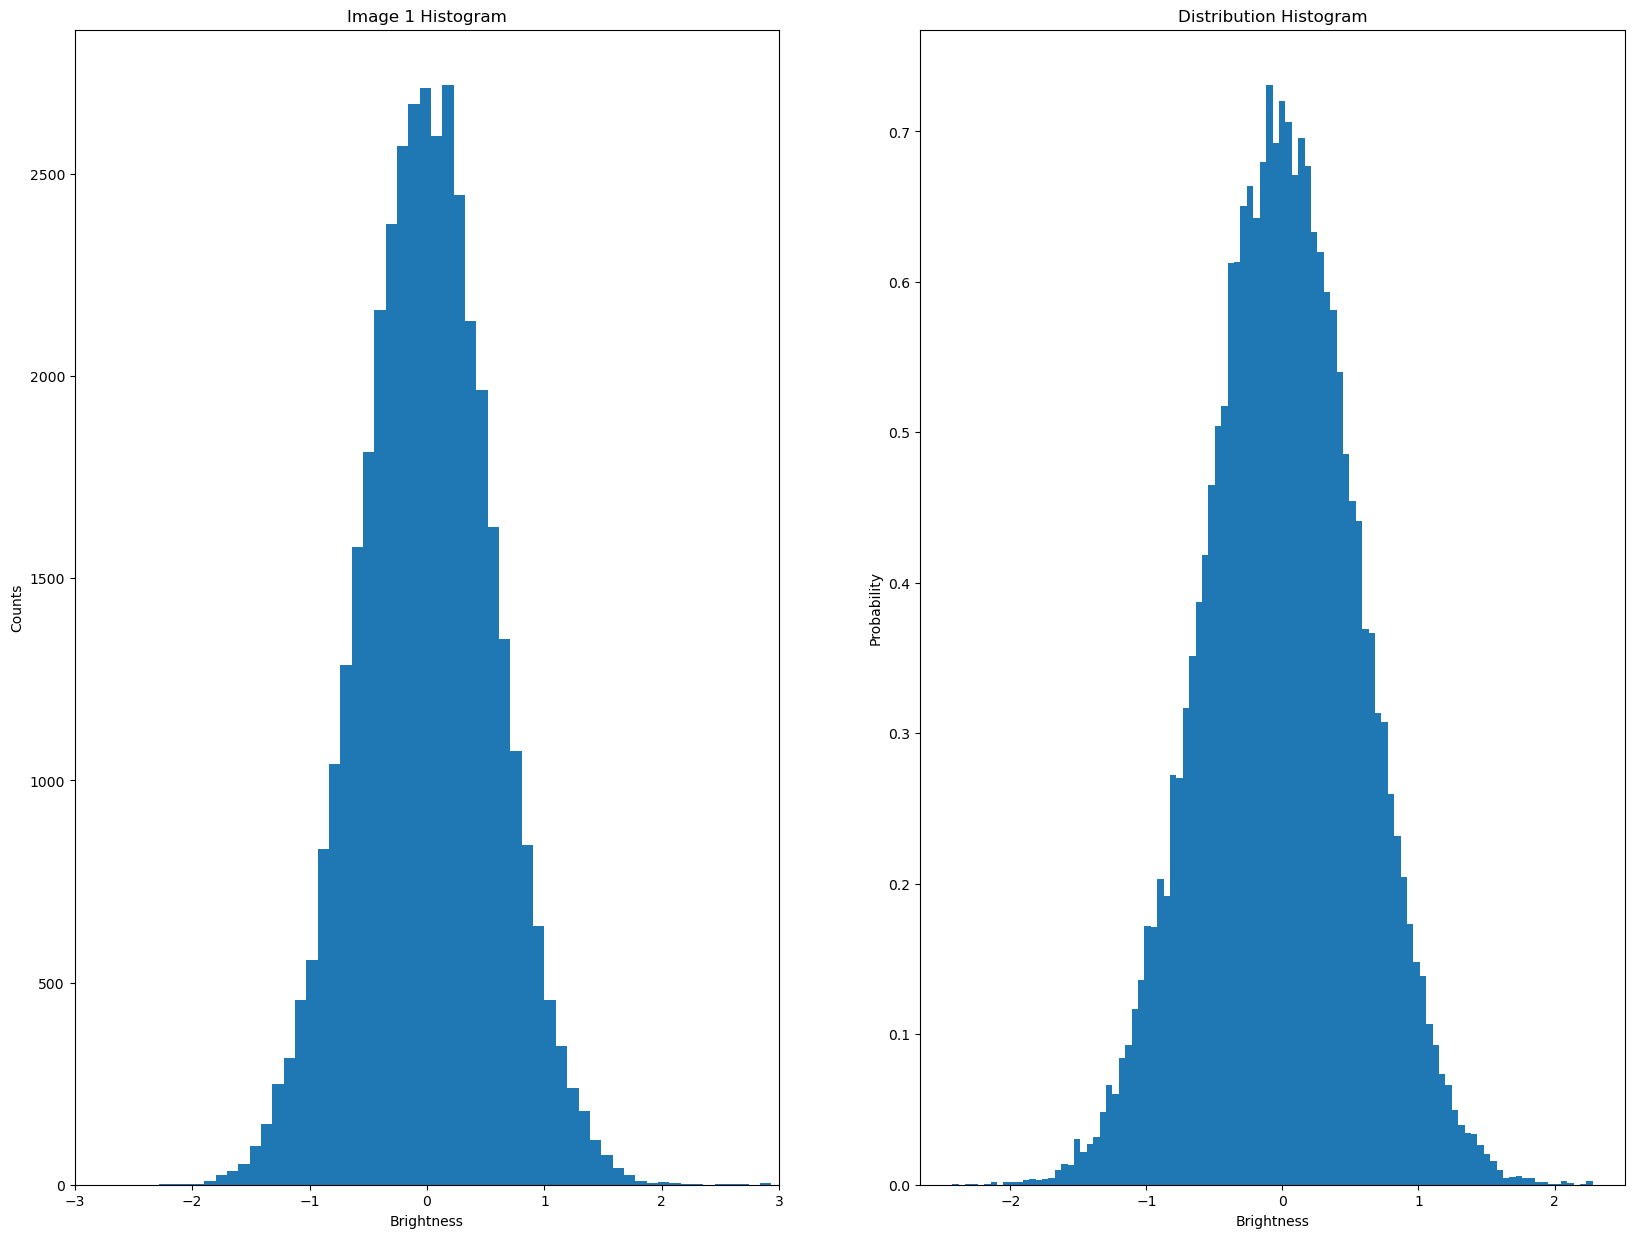

In [28]:
first_image_calc = [x for x in first_image if abs(x) < 2.5]
stdev = np.std(first_image_calc)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(first_image, 500)
ax1.set_xlabel('Brightness')
ax1.set_ylabel('Counts')
ax1.set_title('Image 1 Histogram')
ax1.set_xlim([-3,3])
d = stats.norm.rvs(loc=0,scale=stdev,size=len(first_image_calc))
ax2.hist(d, 100, density=True)
ax2.set_xlabel('Brightness')
ax2.set_ylabel('Probability')
ax2.set_title('Distribution Histogram')
plt.show()

3. The pdf used to describe the background appears to closely follow the original image. As such we'll use this distribution to determine which possible signals are stars using a threshold of 5 sigma as usual.

In [30]:
first_image = data[:,:,0]
x, y = [], []
for i in range(len(first_image)):
    for j in range(len(first_image[0])):
        brightness = first_image[i][j]
        prob = stats.norm.cdf(brightness, loc=0,scale=stdev)
        if stats.norm.ppf(prob) >= 5:
            x.append(i)
            y.append(j)

Text(0.5, 1.0, 'Image 1')

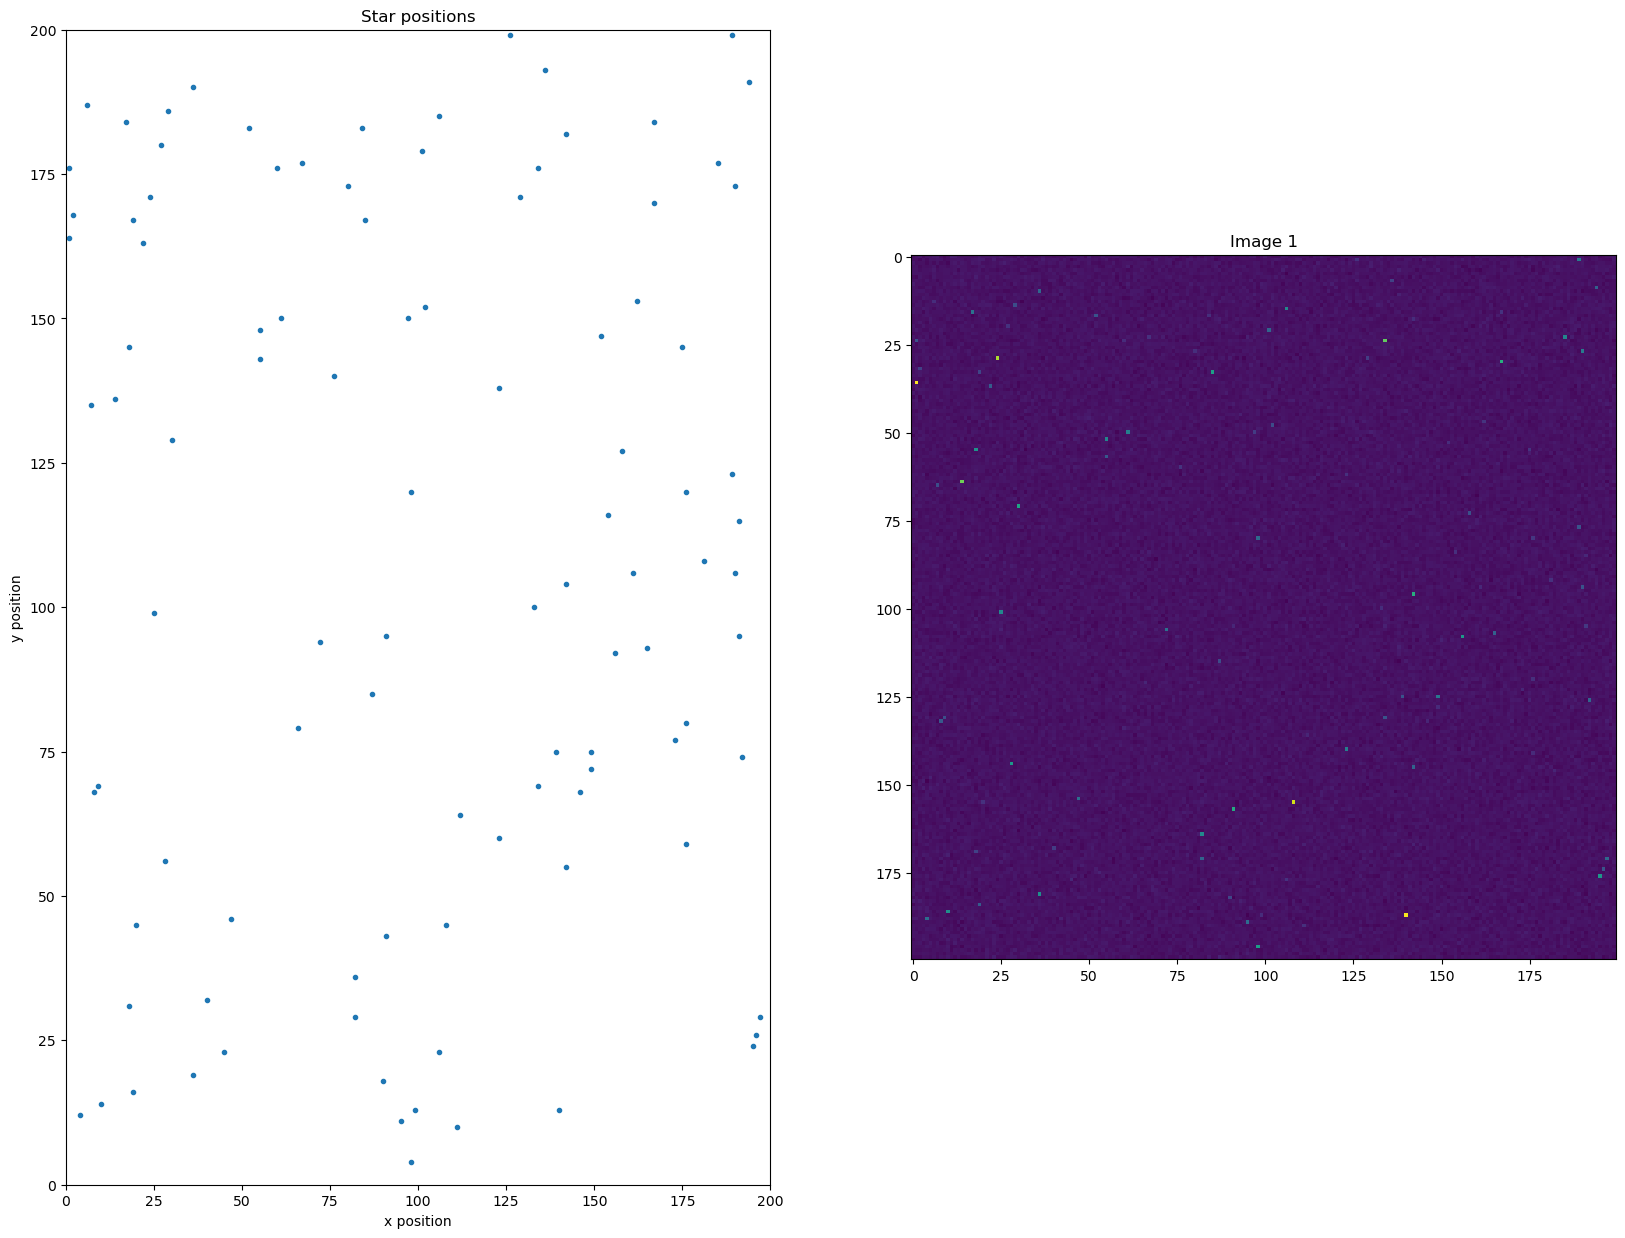

In [31]:
# Plot is rotated 90 degrees counter clockwise for some reason
x, y = y, [(200-a) for a in x]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(x,y, '.')
ax1.set_xlim([0, 200])
ax1.set_ylim([0,200])
ax1.set_xlabel('x position')
ax1.set_ylabel('y position')
ax1.set_title('Star positions')
ax2.imshow(data[:,:,0])
ax2.set_title('Image 1')

As can be seen from these plots, our model finds the stars already visible on the image, to be expected, however it also picks out all stars brighter than an associated sigma of 5 that are not quite visible to the naked eye from the image. It makes sense that there would be faint stars still significantly brighter than the background, as the background has such a small standard deviation

4. When looking for a transient rather than the faintest signals, especially when this transient is only present on one image, it would be better to average all the images together and construct a pdf of that background to find such a rare signal. As such, we would have two different backgrounds.